In [17]:
import torch
import sys
import numpy as np
import pandas as pd
import scanpy.api as sc
from anndata import AnnData

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

sys.path.append("../")
from args_parser import get_parser
from model.mars import MARS
from model.experiment_dataset import ExperimentDataset
from data.benchmarks import BenchmarkData
import warnings
warnings.filterwarnings('ignore')

# Setting parameters

Loading default parameters

In [18]:
params, unknown = get_parser().parse_known_args()

In [19]:
params

Namespace(cuda=False, epochs=30, epochs_pretrain=25, learning_rate=0.001, lr_scheduler_gamma=0.5, lr_scheduler_step=20, manual_seed=3, model_file='trained_models/source.pt', pretrain=True, pretrain_batch=None)

Checking if CUDA device is available

In [20]:
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'
params.device = device

# Loading dataset

Loading Cellbench dataset. Datasets are already concatenated and only the subset of genes that appears in both datasets is retained

In [21]:
adata = sc.read_h5ad('../benchmark_datasets/cellbench.h5ad')
adata

AnnData object with n_obs × n_vars = 4373 × 10217 
    obs: 'experiment', 'ground_truth'

In [22]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.scale(adata, max_value=10, zero_center=True)

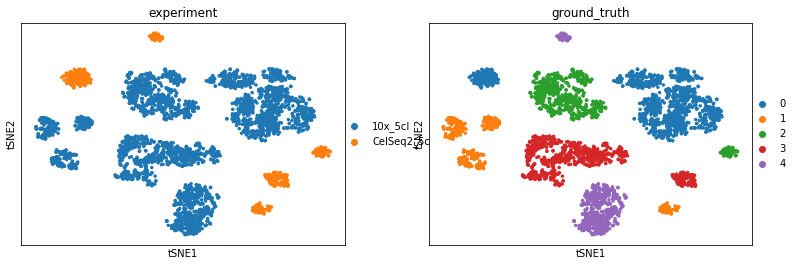

In [23]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')
sc.pp.pca(adata, n_comps=50)
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=['experiment','ground_truth'],size=50)

In [24]:
datasets = list(set(adata.obs['experiment']))
datasets

['10x_5cl', 'CelSeq2_5cl']

# Train and evaluate MARS

### Use 10x as annotated, and CelSeq2 as unannotated 

Prepare annotated, unannotated and pretrain datasets

In [25]:
exp_10x = adata[adata.obs['experiment'] == '10x_5cl',:]
exp_celseq2 = adata[adata.obs['experiment'] == 'CelSeq2_5cl',:]

In [26]:
y_10x = np.array(exp_10x.obs['ground_truth'], dtype=np.int64)
annotated = ExperimentDataset(exp_10x.X.toarray(), exp_10x.obs_names, exp_10x.var_names, '10x', y_10x)

== Dataset: Found 3803 items 
== Dataset: Found 5 classes


In [27]:
y_celseq2 = np.array(exp_celseq2.obs['ground_truth'], dtype=np.int64) # ground truth annotations will be only used for evaluation
unannnotated = ExperimentDataset(exp_celseq2.X.toarray(), exp_celseq2.obs_names, exp_celseq2.var_names, 'celseq2', y_celseq2)

== Dataset: Found 570 items 
== Dataset: Found 5 classes


In [28]:
pretrain_data = ExperimentDataset(exp_celseq2.X.toarray(), exp_celseq2.obs_names, exp_celseq2.var_names, 'celseq2')

In [29]:
n_clusters = len(np.unique(unannnotated.y))

Initialize MARS

In [30]:
mars = MARS(n_clusters, params, [annotated], unannnotated, pretrain_data, hid_dim_1=1000, hid_dim_2=100)

Run MARS in evaluation mode. Ground truth annotations will be used to evaluate MARS performance and scores will be returned

In [31]:
# return only unannotated dataset with save_all_embeddings=False
adata, landmarks, scores = mars.train(evaluation_mode=True, save_all_embeddings=False) # evaluation mode

Pretraining..

=== Epoch: 30 ===
Train acc: 1.0


In [32]:
adata

AnnData object with n_obs × n_vars = 570 × 10217 
    obs: 'MARS_labels', 'truth_labels'
    uns: 'MARS_embedding'
    obsm: 'MARS_embedding'

Check MARS performance

In [33]:
scores

{'accuracy': 1.0,
 'adj_mi': 1.0,
 'adj_rand': 1.0,
 'f1_score': 1.0,
 'nmi': 1.0,
 'precision': 1.0,
 'recall': 1.0}

Visualize in MARS embedding space

In [35]:
#create anndata object using MARS embeddings as X
adata_mars = AnnData(adata.obsm['MARS_embedding'])
adata_mars.obs['MARS_labels'] = pd.Categorical(adata.obs['MARS_labels'])
adata_mars.obs['ground_truth'] = pd.Categorical(adata.obs['truth_labels'])

In [36]:
np.shape(adata_mars.X) # 100-dimensional MARS embeddings space

(570, 100)

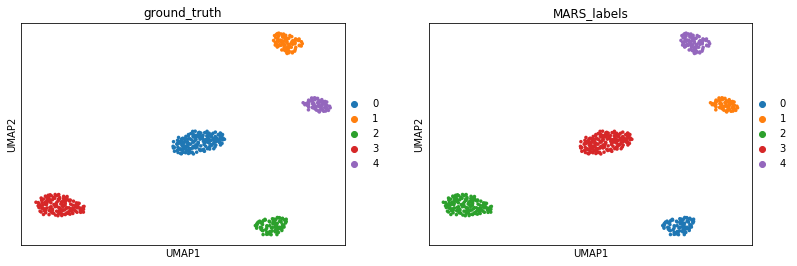

In [38]:
# visualize only unannotated dataset
sc.pp.neighbors(adata_mars, n_neighbors=30, use_rep='X')
sc.tl.umap(adata_mars)
sc.pl.umap(adata_mars, color=['ground_truth','MARS_labels'],size=50)

### Use CelSeq2 as annotated, and 10x as unannotated 

In [39]:
annotated = ExperimentDataset(exp_celseq2.X.toarray(), exp_celseq2.obs_names, exp_celseq2.var_names, 'celseq2', y_celseq2)
unannnotated = ExperimentDataset(exp_10x.X.toarray(), exp_10x.obs_names, exp_10x.var_names, '10x', y_10x)
pretrain_data = ExperimentDataset(exp_10x.X.toarray(), exp_10x.obs_names, exp_10x.var_names, '10x')
n_clusters = len(np.unique(unannnotated.y))

== Dataset: Found 570 items 
== Dataset: Found 5 classes
== Dataset: Found 3803 items 
== Dataset: Found 5 classes


Run MARS

In [40]:
mars = MARS(n_clusters, params, [annotated], unannnotated, pretrain_data, hid_dim_1=1000, hid_dim_2=100)

In [42]:
adata, landmarks, scores = mars.train(evaluation_mode=True, save_all_embeddings=False)

Pretraining..

=== Epoch: 30 ===
Train acc: 1.0


In [38]:
scores

{'accuracy': 1.0,
 'adj_mi': 1.0,
 'adj_rand': 1.0,
 'f1_score': 1.0,
 'nmi': 1.0,
 'precision': 1.0,
 'recall': 1.0}

In [39]:
#create anndata object using MARS embeddings as X
adata_mars = AnnData(adata.obsm['MARS_embedding'])
adata_mars.obs['MARS_labels'] = pd.Categorical(adata.obs['MARS_labels'])
adata_mars.obs['ground_truth'] = pd.Categorical(adata.obs['truth_labels'])

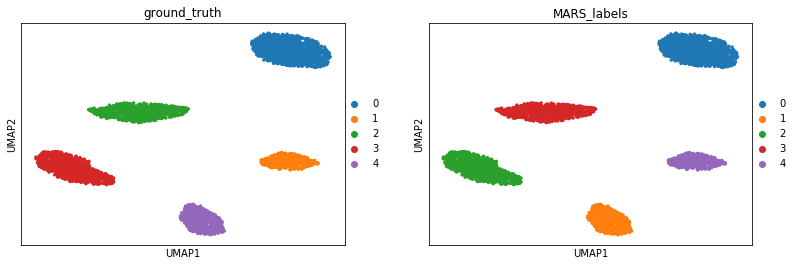

In [41]:
# visualize only unannotated dataset
sc.pp.neighbors(adata_mars, n_neighbors=30, use_rep='X')
sc.tl.umap(adata_mars)
sc.pl.umap(adata_mars, color=['ground_truth','MARS_labels'],size=50)